In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import scipy
import sys
sys.path.append("..")
import bayesian_anova

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
cols = ['experiment_name',
        'test_acc',
        'train_time',
        'entropy__auc',
        'entropy_expectation__auc',
        'classifier__auc']

In [3]:
experiments = ['mlp', 'mlp-dropout', 'mlp-poor-bayesian']

In [4]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_with_unknown.csv')
    df_with_results = df_with[cols].set_index('experiment_name') #df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_out_unknown.csv')
    df_without_results = df_without[cols].set_index('experiment_name') #df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [5]:
results_cols = ['experiment',
                'in_test_acc', 'out_test_acc',
                'in_train_time', 'out_train_time',
                'in_entropy_auc', 'out_entropy_auc',
                'in_entropy_expectation_auc', 'out_entropy_expectation_auc',
                'in_classifier_auc', 'out_classifier_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            str(in_key),
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
            in_row[3], out_row[3],
            in_row[4], out_row[4],
        ]
    dfs_results.append([exp, results])

In [6]:
final_results_cols = ['experiment']
for c in results_cols[1:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [7]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        
    _, *row = key_row[0]
    new_row = [row[0]]
    
    for c in range(1, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [8]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

In [9]:
out_acc = ['mlp_out_classifier_auc', 'mlp-dropout_out_classifier_auc', 'mlp-poor-bayesian_out_classifier_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['mlp_in_classifier_auc', 'mlp-dropout_in_classifier_auc', 'mlp-poor-bayesian_in_classifier_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 2.98  5.5e-4   0.04   2.91   2.95   2.98    3.0   3.04   4000    1.0
theta_free[0]     -0.13  8.6e-4   0.05  -0.24  -0.17  -0.13   -0.1  -0.02   4000    1.0
theta_free[1]      0.09  8.0e-4   0.05  -0.01   0.05   0.09   0.12   0.19   4000    1.0
sigma_likelihood   0.61  3.9e-4   0.02   0.56   0.59    0.6   0.62   0.66   4000    1.0
sigma_theta        0.61    0.03   1.74   0.03   0.13   0.23   0.48   3.79   4000    1.0
theta[0]          -0.13  8.6e-4   0.05  -0.24  -0.17  -0.13   -0.1  -0.02   4000    1.0
theta[1]           0.09  8.0e-4   0.05  -0.01   0.05   0.09   0.12   0.19   4000    1.0
theta[2]           0.05  7.7e-4   0.05  -0.05   0.01   0.04   0.08   0.14   4000    1.0
lp__              

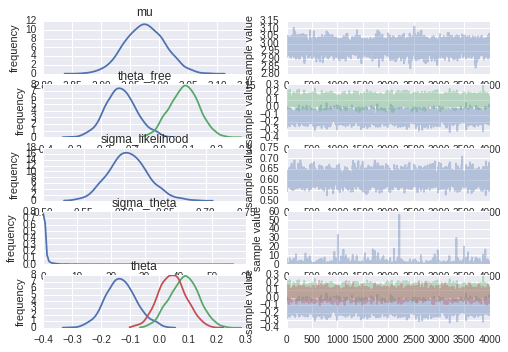

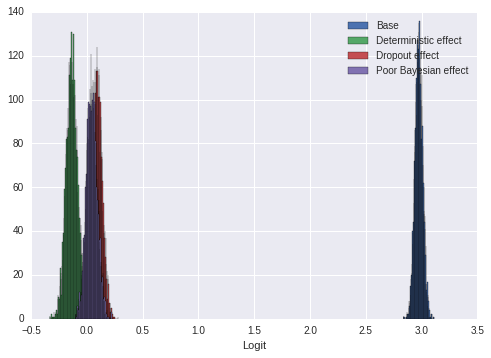

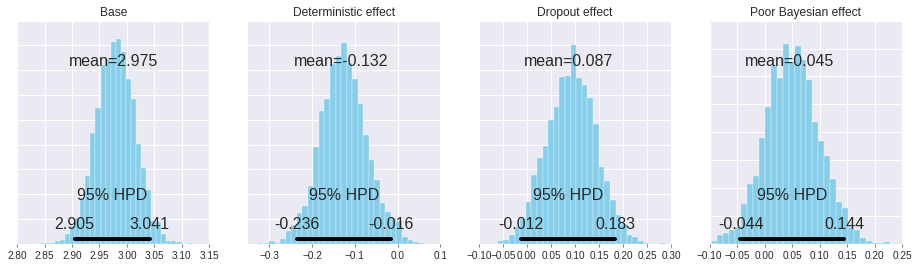

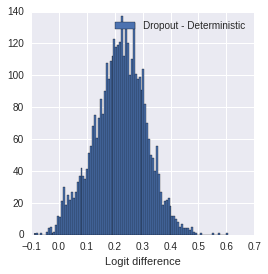

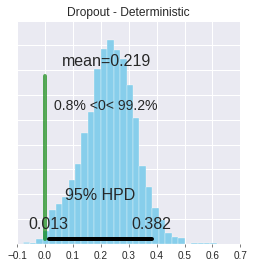

Dropout - Deterministic 95.0 CI: 0.0236462350333 0.395127343632 Pr > 0: 0.99175


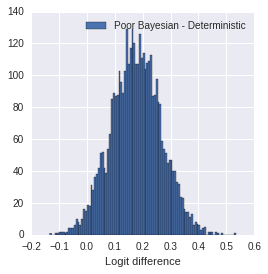

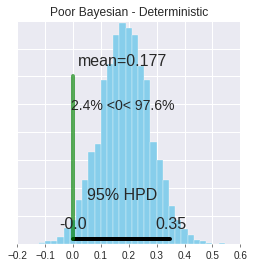

Poor Bayesian - Deterministic 95.0 CI: 0.00163622448467 0.354046865914 Pr > 0: 0.97625


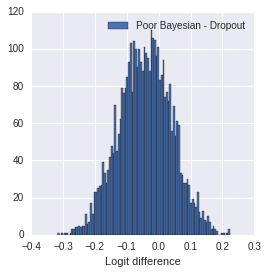

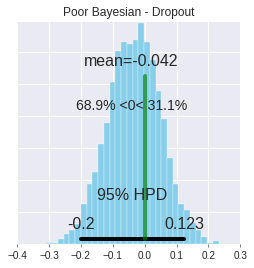

Poor Bayesian - Dropout 95.0 CI: -0.200764452996 0.122355714207 Pr > 0: 0.311


/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 2.17  4.5e-4   0.03   2.11   2.15   2.17   2.19   2.23   4000    1.0
theta_free[0]     -0.24  6.6e-4   0.04  -0.33  -0.27  -0.25  -0.22  -0.16   4000    1.0
theta_free[1]      0.15  6.5e-4   0.04   0.07   0.12   0.15   0.17   0.23   4000    1.0
sigma_likelihood   0.49  3.2e-4   0.02   0.45   0.48   0.49   0.51   0.53   4000    1.0
sigma_theta        1.03    0.04   2.57   0.12   0.24   0.41   0.84   5.75   4000    1.0
theta[0]          -0.24  6.6e-4   0.04  -0.33  -0.27  -0.25  -0.22  -0.16   4000    1.0
theta[1]           0.15  6.5e-4   0.04   0.07   0.12   0.15   0.17   0.23   4000    1.0
theta[2]            0.1  6.3e-4   0.04   0.02   0.07    0.1   0.12   0.17   4000    1.0
lp__              

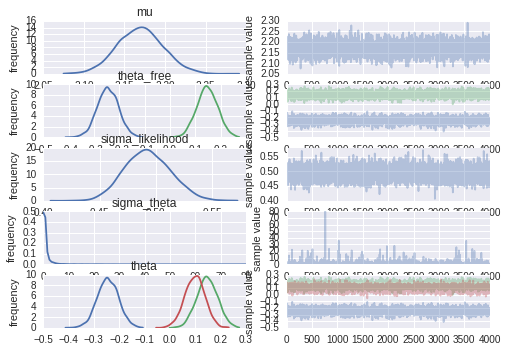

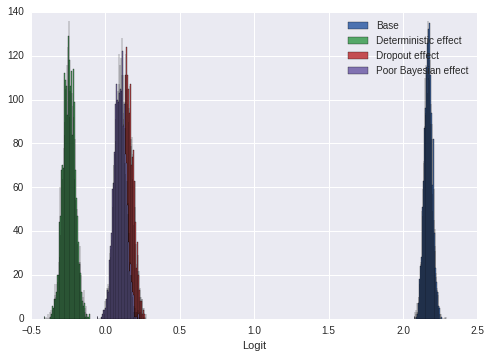

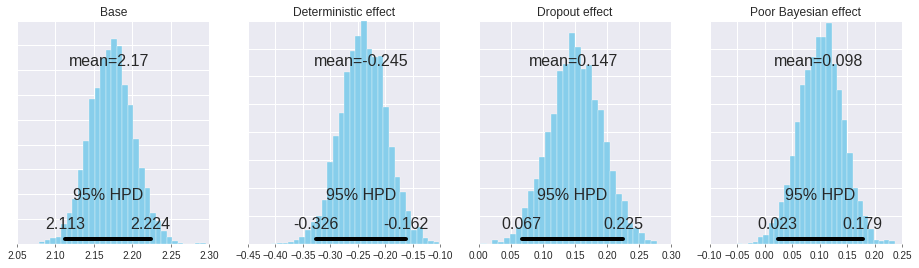

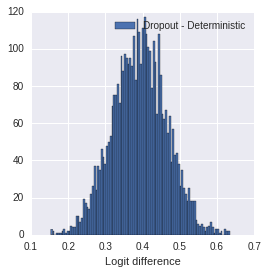

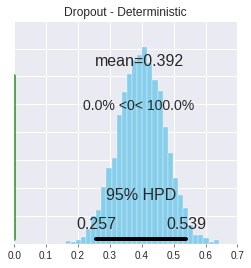

Dropout - Deterministic 95.0 CI: 0.248394353068 0.534392958875 Pr > 0: 1.0


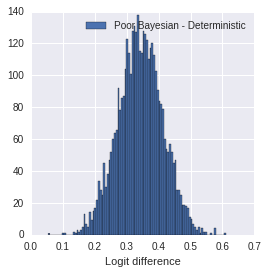

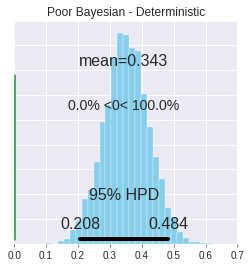

Poor Bayesian - Deterministic 95.0 CI: 0.204707123439 0.481343244079 Pr > 0: 1.0


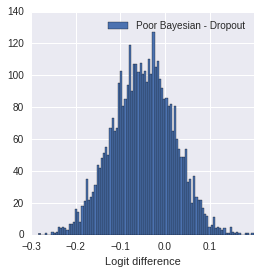

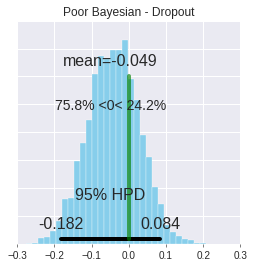

Poor Bayesian - Dropout 95.0 CI: -0.18347281901 0.0823851307396 Pr > 0: 0.2425


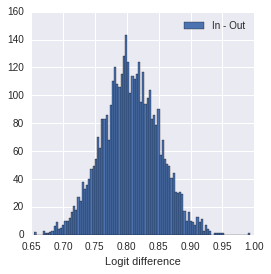

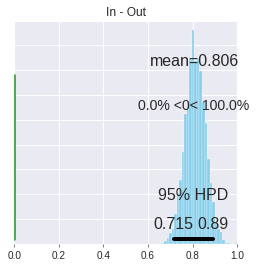

In - Out 95.0 CI: 0.717968953258 0.894060118059 Pr > 0: 1.0


In [10]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    poor_bayesian = trace['theta'][:,2]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout, poor_bayesian],
                               ["Base", "Deterministic effect", "Dropout effect", "Poor Bayesian effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
    bayesian_anova.effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
    bayesian_anova.effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'In', 'Out')

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_4a949e6e1228fe8484bc6e4a7ca415af.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_in              2.98  4.9e-4   0.03   2.92   2.95   2.98    3.0   3.04   4000    1.0
mu_out             2.17  5.1e-4   0.03   2.11   2.15   2.17   2.19   2.23   4000    1.0
theta_free[0]      -0.2  5.0e-4   0.03  -0.26  -0.22   -0.2  -0.17  -0.13   4000    1.0
theta_free[1]      0.12  5.0e-4   0.03   0.06    0.1   0.12   0.14   0.18   4000    1.0
sigma_likelihood   0.55  2.5e-4   0.02   0.52   0.54   0.55   0.56   0.58   4000    1.0
sigma_theta        0.88    0.04   2.41    0.1    0.2   0.34   0.72   5.15   4000    1.0
theta[0]           -0.2  5.0e-4   0.03  -0.26  -0.22   -0.2  -0.17  -0.13   4000    1.0
theta[1]           0.12  5.0e-4   0.03   0.06    0.1   0.12   0.14   0.18   4000    1.0
theta[2]          

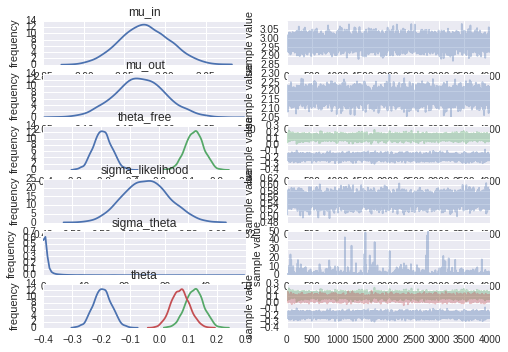

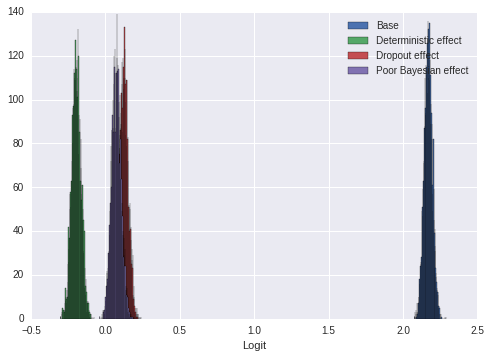

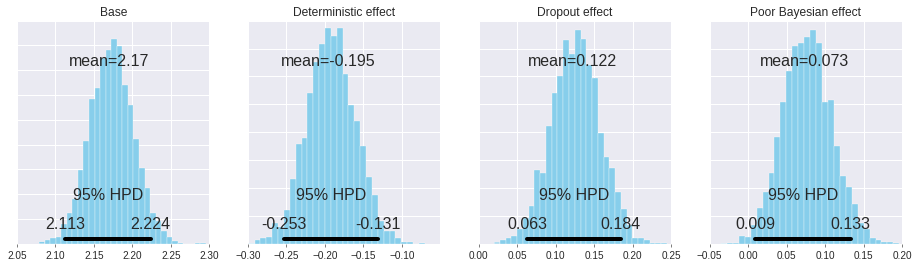

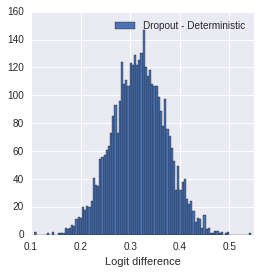

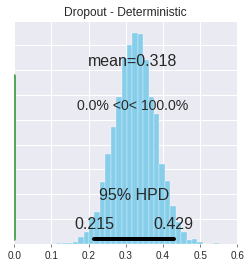

Dropout - Deterministic 95.0 CI: 0.209214953484 0.423968326709 Pr > 0: 1.0


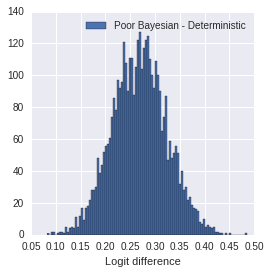

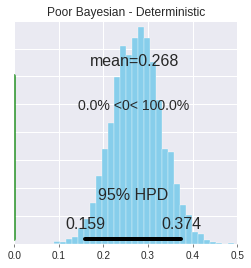

Poor Bayesian - Deterministic 95.0 CI: 0.162507873253 0.377827391054 Pr > 0: 1.0


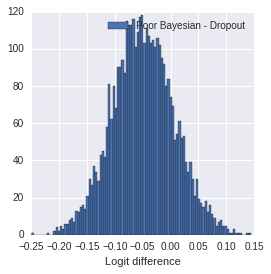

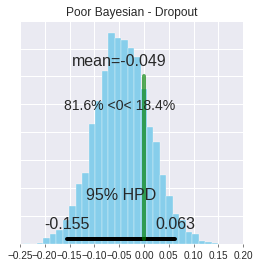

Poor Bayesian - Dropout 95.0 CI: -0.156836889919 0.0625759795649 Pr > 0: 0.18425


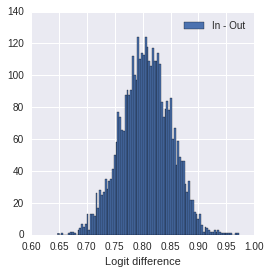

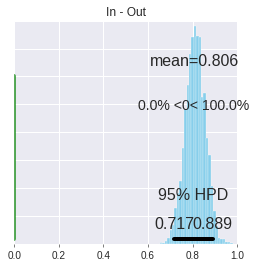

In - Out 95.0 CI: 0.717509615634 0.889889432466 Pr > 0: 1.0


In [11]:
model = pystan.StanModel(model_code=bayesian_anova.two_way_code)

data = {'K': K, 'N': N, 'y_in': y_in, 'y_out': y_out}
fit = model.sampling(data=data, iter=10000, chains=4, thin=5)

bayesian_anova.show_results(fit)

trace = fit.extract()
deterministic = trace['theta'][:,0]
dropout = trace['theta'][:,1]
poor_bayesian = trace['theta'][:,2]
in_mean = trace['mu_in']
out_mean = trace['mu_out']

bayesian_anova.plot_traces([base_mean, deterministic, dropout, poor_bayesian],
                           ["Base", "Deterministic effect", "Dropout effect", "Poor Bayesian effect"])

bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
bayesian_anova.effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
bayesian_anova.effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'In', 'Out')